In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, metrics, Model
from keras_facenet import FaceNet
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/

In [3]:
DATASET_PATH = "C:/Users/DELL/Downloads/datasets/FairFace" 
BATCH_SIZE = 32
IMG_SIZE = 160
EPOCHS = 20
SAMPLE_SIZE = 20000 

In [4]:
TRAIN_CSV_PATH = os.path.join(DATASET_PATH, "train_labels.csv")
VAL_CSV_PATH = os.path.join(DATASET_PATH, "val_labels.csv")
TRAIN_IMG_DIR = os.path.join(DATASET_PATH, "train")
VAL_IMG_DIR = os.path.join(DATASET_PATH, "val")

MODEL_SAVE_PATH = "fairface_multitask_model.keras"
ENCODERS_SAVE_PATH = "label_encoders.pkl"
TRAINING_LOG_PATH = "fairface_training_log.csv"

In [ ]:
class FairFaceDataProcessor:
    def __init__(self, csv_path, img_dir, img_size=160, sample_size=None, is_validation=False):
        self.img_size = img_size
        self.img_dir = img_dir
        self.is_validation = is_validation

        # Load CSV data
        self.df = pd.read_csv(csv_path)
        print(f"Loaded {'validation' if is_validation else 'training'} data: {len(self.df)} samples")

        # Filter dataset to keep only valid age groups
        valid_age_groups = [
            '0-2', '3-9', '10-19', '20-29', '30-39',
            '40-49', '50-59', '60-69', 'more than 70'
        ]
        original_len = len(self.df)
        self.df = self.df[self.df['age'].isin(valid_age_groups)].reset_index(drop=True)
        print(f"Removed {original_len - len(self.df)} rows with invalid age groups")

        # Sample data if specified
        if sample_size and sample_size < len(self.df):
            self.df = self.df.sample(n=sample_size, random_state=42).reset_index(drop=True)
            print(f"Sampled {'validation' if is_validation else 'training'}: {len(self.df)} samples")

        # Initialize label encoders
        self.age_encoder = LabelEncoder()
        self.gender_encoder = LabelEncoder()
        self.race_encoder = LabelEncoder()

        # Fit encoders
        self.age_encoder.fit(self.df['age'])
        self.gender_encoder.fit(self.df['gender'])
        self.race_encoder.fit(self.df['race'])

        # Encode labels
        self.df['age_encoded'] = self.age_encoder.transform(self.df['age'])
        self.df['gender_encoded'] = (self.df['gender'] == 'Male').astype(int) 
        self.df['race_encoded'] = self.race_encoder.transform(self.df['race'])

        self.num_classes = {
            'age': len(self.age_encoder.classes_),
            'gender': 2, 
            'race': len(self.race_encoder.classes_)
        }

        print(f"Classes - Age: {self.num_classes['age']}, Gender: {self.num_classes['gender']}, Race: {self.num_classes['race']}")
        if not is_validation:
            print(f"Age groups: {list(self.age_encoder.classes_)}")
            print(f"Gender groups: {list(self.gender_encoder.classes_)}")
            print(f"Race groups: {list(self.race_encoder.classes_)}")

    def filter_missing_files(self):
        """Filter out rows where image files don't exist"""
        print(f"Original dataset size: {len(self.df)}")

        existing_files = []
        for idx, row in self.df.iterrows():
            img_path = os.path.join(self.img_dir, row['file'])
            if os.path.exists(img_path):
                existing_files.append(idx)

        self.df = self.df.loc[existing_files].reset_index(drop=True)
        print(f"Filtered dataset size: {len(self.df)}")
        return self

    def load_and_preprocess_image(self, image_path, augment=False):
        """Load and preprocess single image"""
        try:
            if not tf.io.gfile.exists(image_path):
                print(f"Warning: File not found: {image_path}")
                return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
            image = tf.image.resize(image, [self.img_size, self.img_size])
            image = tf.cast(image, tf.float32) / 255.0

            if augment:
                # Data augmentation
                image = tf.image.random_flip_left_right(image)
                image = tf.image.random_brightness(image, 0.1)
                image = tf.image.random_contrast(image, 0.9, 1.1)
                image = tf.image.random_saturation(image, 0.9, 1.1)
                image = tf.image.random_hue(image, 0.05)

            # Normalize using ImageNet statistics 
            image = tf.image.per_image_standardization(image)
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return tf.zeros([self.img_size, self.img_size, 3], dtype=tf.float32)

    def create_dataset(self, batch_size=32, augment=False, shuffle=True):
        """Create TensorFlow dataset"""
        def generator():
            indices = np.arange(len(self.df))
            if shuffle:
                np.random.shuffle(indices)

            for idx in indices:
                row = self.df.iloc[idx]
                img_path = os.path.join(self.img_dir, row['file'])
                image = self.load_and_preprocess_image(img_path, augment)

                yield (
                    image,
                    {
                        'age_output': tf.cast(row['age_encoded'], dtype=tf.int32),
                        'gender_output': tf.cast(row['gender_encoded'], dtype=tf.int32),
                        'race_output': tf.cast(row['race_encoded'], dtype=tf.int32)
                    }
                )

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.img_size, self.img_size, 3), dtype=tf.float32),
                {
                    'age_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'gender_output': tf.TensorSpec(shape=(), dtype=tf.int32),
                    'race_output': tf.TensorSpec(shape=(), dtype=tf.int32)
                }
            )
        )

        if shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

In [5]:
@tf.keras.utils.register_keras_serializable()
class FaceNetMultiTask(tf.keras.Model):
    def __init__(self, num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=False, **kwargs):
        super(FaceNetMultiTask, self).__init__(**kwargs)
        
        self.num_age_classes = num_age_classes
        self.num_gender_classes = num_gender_classes
        self.num_race_classes = num_race_classes
        self.freeze_backbone = freeze_backbone
        
        # Initialize FaceNet backbone
        self.backbone = FaceNet().model
        if freeze_backbone:
            self.backbone.trainable = False

        # Shared dense layer
        self.shared_dense = layers.Dense(512, activation='relu', name='shared_dense')
        self.shared_dropout = layers.Dropout(0.7, name='shared_dropout')

        # Task-specific classification heads
        self.age_dense = layers.Dense(128, activation='relu', name='age_dense')
        self.age_output = layers.Dense(num_age_classes, activation='softmax', name='age_output')
        
        self.gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')
        
        self.race_output = layers.Dense(num_race_classes, activation='softmax', name='race_output')

    def call(self, inputs, training=None):
        # Get FaceNet embeddings
        embeddings = self.backbone(inputs, training=training)
        
        # Shared processing
        shared_features = self.shared_dense(embeddings, training=training)
        shared_features = self.shared_dropout(shared_features, training=training)
        
        # Task-specific predictions
        age_features = self.age_dense(shared_features, training=training)
        age_pred = self.age_output(age_features, training=training)
        
        gender_pred = self.gender_output(shared_features, training=training)
        race_pred = self.race_output(shared_features, training=training)

        return {
            'age_output': age_pred,
            'gender_output': gender_pred,
            'race_output': race_pred
        }
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_age_classes': self.num_age_classes,
            'num_gender_classes': self.num_gender_classes,
            'num_race_classes': self.num_race_classes,
            'freeze_backbone': self.freeze_backbone
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [47]:
def create_and_compile_model(num_age_classes, num_gender_classes, num_race_classes, freeze_backbone=True):
    """Create and compile the multi-task model"""
    
    model = FaceNetMultiTask(
        num_age_classes=num_age_classes,
        num_gender_classes=num_gender_classes,
        num_race_classes=num_race_classes,
        freeze_backbone=freeze_backbone
    )

    # Build the model
    model.build((None, IMG_SIZE, IMG_SIZE, 3))

    # Compile model
    initial_lr = 0.001
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss={
            'age_output': losses.SparseCategoricalCrossentropy(),
            'gender_output': losses.BinaryCrossentropy(),
            'race_output': losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'age_output': 1.0,
            'gender_output': 1.0,
            'race_output': 1.0
        },
        metrics={
            'age_output': ['sparse_categorical_accuracy'],
            'gender_output': ['binary_accuracy'],
            'race_output': ['sparse_categorical_accuracy']
        }
    )

    print(f"\nModel compiled successfully!")
    print(f"   - Backbone frozen: {freeze_backbone}")
    print(f"   - Learning rate: {initial_lr}")
    
    return model

In [48]:
print("Creating training data processor...")
train_processor = FairFaceDataProcessor(
    TRAIN_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE,
    is_validation=False
).filter_missing_files()

print("\nCreating validation data processor...")
val_processor = FairFaceDataProcessor(
    VAL_CSV_PATH,
    DATASET_PATH,
    img_size=IMG_SIZE,
    sample_size=SAMPLE_SIZE//5 if SAMPLE_SIZE else None,
    is_validation=True
).filter_missing_files()

# Copy encoders from training to validation processor
val_processor.age_encoder = train_processor.age_encoder
val_processor.gender_encoder = train_processor.gender_encoder
val_processor.race_encoder = train_processor.race_encoder

# Re-encode validation labels with training encoders
val_processor.df['age_encoded'] = val_processor.age_encoder.transform(val_processor.df['age'])
val_processor.df['gender_encoded'] = (val_processor.df['gender'] == 'Male').astype(int)
val_processor.df['race_encoded'] = val_processor.race_encoder.transform(val_processor.df['race'])

print("\nCreating datasets...")
train_dataset = train_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=True,
    shuffle=True
)

val_dataset = val_processor.create_dataset(
    batch_size=BATCH_SIZE,
    augment=False,
    shuffle=False
)


Creating training data processor...
Loaded training data: 86744 samples
Removed 0 rows with invalid age groups
Sampled training: 20000 samples
Classes - Age: 9, Gender: 2, Race: 7
Age groups: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender groups: ['Female', 'Male']
Race groups: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']
Original dataset size: 20000
Filtered dataset size: 20000

Creating validation data processor...
Loaded validation data: 10954 samples
Removed 0 rows with invalid age groups
Sampled validation: 4000 samples
Classes - Age: 9, Gender: 2, Race: 7
Original dataset size: 4000
Filtered dataset size: 4000

Creating datasets...


In [ ]:
print("Building model...")
model = create_and_compile_model(
    num_age_classes=train_processor.num_classes['age'],
    num_gender_classes=train_processor.num_classes['gender'],
    num_race_classes=train_processor.num_classes['race'],
    freeze_backbone=True
)

print("\nModel Summary:")
model.summary()


In [50]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(TRAINING_LOG_PATH)
]

In [51]:
# print("Starting training...")
# history = model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,
#     callbacks=callbacks,
#     verbose=1
# )

# print("Training completed!")

In [ ]:
encoders = {
    'age_encoder': train_processor.age_encoder,
    'gender_encoder': train_processor.gender_encoder,
    'race_encoder': train_processor.race_encoder
}

with open(ENCODERS_SAVE_PATH, 'wb') as f:
    pickle.dump(encoders, f)

# Save model weights
# weights_path = "fair_weights.h5"
# model.save_weights(weights_path)


print(f"Label encoders saved to {ENCODERS_SAVE_PATH}")
print(f"Model saved to {MODEL_SAVE_PATH}")
# print(f"Model weights saved as {weights_path}")

Label encoders saved to label_encoders.pkl
Model saved to fairface_multitask_model.keras


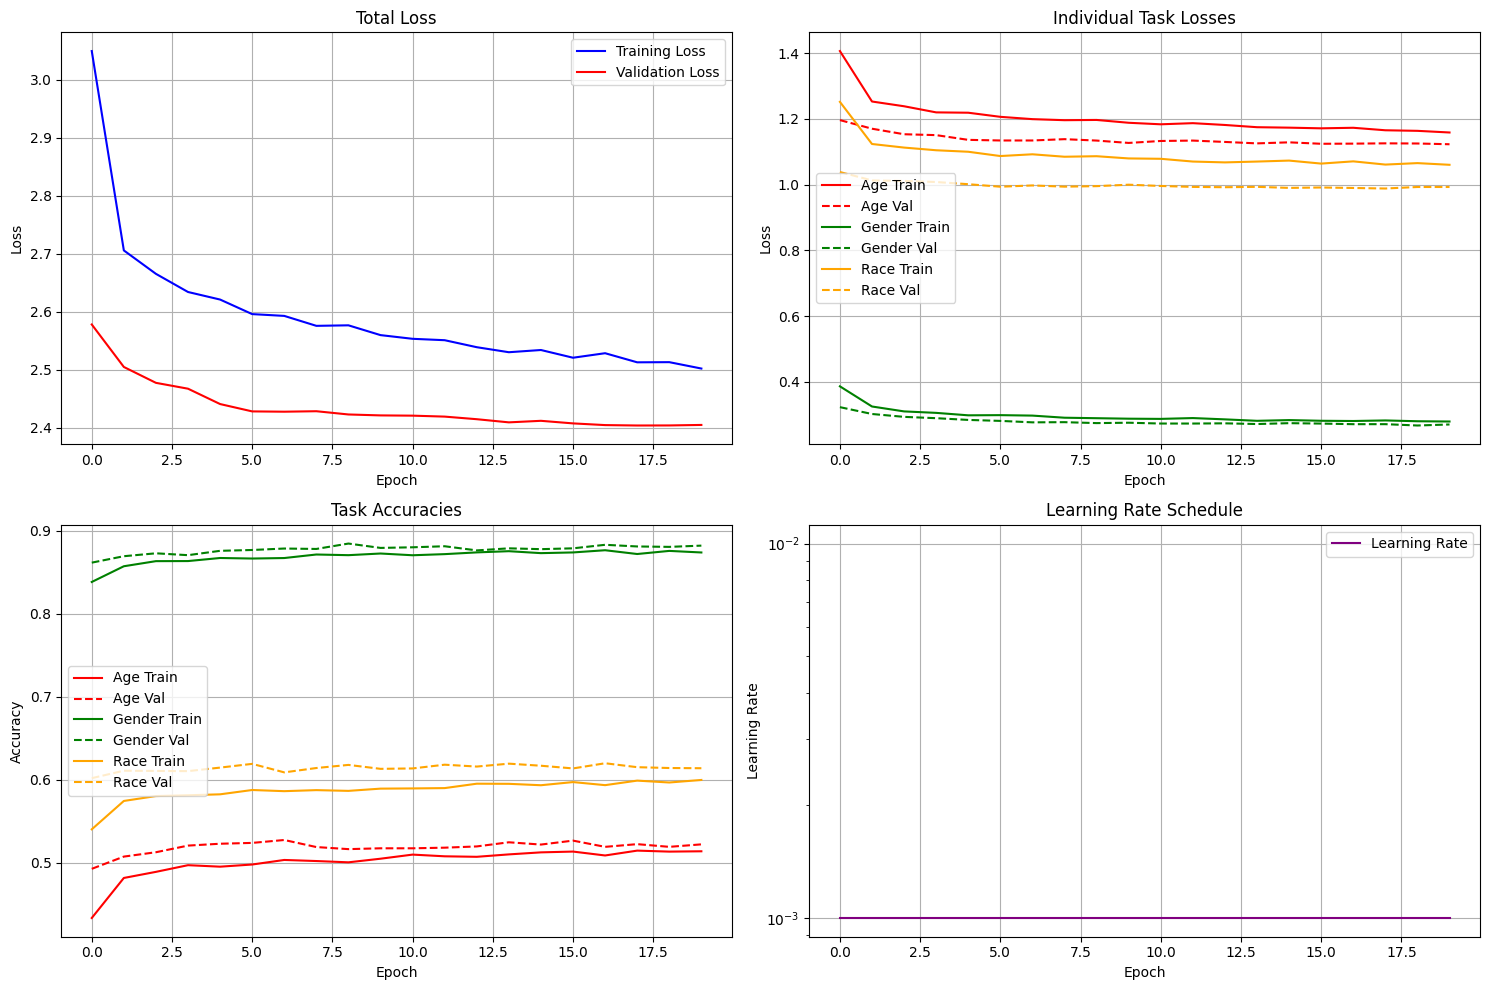


Final Training Metrics:
Total Loss: 2.5025 | Val Loss: 2.4052
Age Accuracy: 0.5139 | Val: 0.5222
Gender Accuracy: 0.8740 | Val: 0.8823
Race Accuracy: 0.5998 | Val: 0.6140


In [53]:
def plot_training_history(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Total Loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Individual Task Losses
    ax2.plot(history.history['age_output_loss'], label='Age Train', color='red', linestyle='-')
    ax2.plot(history.history['val_age_output_loss'], label='Age Val', color='red', linestyle='--')
    ax2.plot(history.history['gender_output_loss'], label='Gender Train', color='green', linestyle='-')
    ax2.plot(history.history['val_gender_output_loss'], label='Gender Val', color='green', linestyle='--')
    ax2.plot(history.history['race_output_loss'], label='Race Train', color='orange', linestyle='-')
    ax2.plot(history.history['val_race_output_loss'], label='Race Val', color='orange', linestyle='--')
    ax2.set_title('Individual Task Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Task Accuracies
    ax3.plot(history.history['age_output_sparse_categorical_accuracy'], label='Age Train', color='red', linestyle='-')
    ax3.plot(history.history['val_age_output_sparse_categorical_accuracy'], label='Age Val', color='red', linestyle='--')
    ax3.plot(history.history['gender_output_binary_accuracy'], label='Gender Train', color='green', linestyle='-')
    ax3.plot(history.history['val_gender_output_binary_accuracy'], label='Gender Val', color='green', linestyle='--')
    ax3.plot(history.history['race_output_sparse_categorical_accuracy'], label='Race Train', color='orange', linestyle='-')
    ax3.plot(history.history['val_race_output_sparse_categorical_accuracy'], label='Race Val', color='orange', linestyle='--')
    ax3.set_title('Task Accuracies')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Learning Rate
    ax4.plot(history.history.get('learning_rate', []), label='Learning Rate', color='purple')
    ax4.set_title('Learning Rate Schedule')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Learning Rate')
    ax4.legend()
    ax4.grid(True)
    ax4.set_yscale('log')

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("\nFinal Training Metrics:")
    print(f"Total Loss: {history.history['loss'][-1]:.4f} | Val Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Age Accuracy: {history.history['age_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_age_output_sparse_categorical_accuracy'][-1]:.4f}")
    print(f"Gender Accuracy: {history.history['gender_output_binary_accuracy'][-1]:.4f} | Val: {history.history['val_gender_output_binary_accuracy'][-1]:.4f}")
    print(f"Race Accuracy: {history.history['race_output_sparse_categorical_accuracy'][-1]:.4f} | Val: {history.history['val_race_output_sparse_categorical_accuracy'][-1]:.4f}")

plot_training_history(history)

In [20]:
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import quickshift
import shap
from PIL import Image

In [21]:
IMG_SIZE = 160
MODEL_SAVE_PATH = "fairface_multitask_model.keras"
ENCODERS_SAVE_PATH = "label_encoders.pkl"


# Load the trained model
print("Loading model...")
try:
    model = tf.keras.models.load_model(MODEL_SAVE_PATH, compile=False)
    print(f"Model loaded successfully from {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please ensure the model file exists and was saved correctly during training.")
    raise

# Load label encoders
print("Loading label encoders...")
try:
    with open(ENCODERS_SAVE_PATH, 'rb') as f:
        encoders = pickle.load(f)
    
    age_encoder = encoders['age_encoder']
    gender_encoder = encoders['gender_encoder']
    race_encoder = encoders['race_encoder']
    
    print("Label encoders loaded successfully")
    print(f"Age classes: {list(age_encoder.classes_)}")
    print(f"Gender classes: {list(gender_encoder.classes_)}")
    print(f"Race classes: {list(race_encoder.classes_)}")
    
except Exception as e:
    print(f"Error loading encoders: {e}")
    print("Please ensure the encoders file exists and was saved correctly during training.")
    raise


Loading model...
Model loaded successfully from fairface_multitask_model.keras
Loading label encoders...
Label encoders loaded successfully
Age classes: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']
Gender classes: ['Female', 'Male']
Race classes: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']


In [22]:
def preprocess_image(image_path, img_size=IMG_SIZE):
    """Preprocess image for model prediction - matching training preprocessing"""
    try:
        # Load image
        if isinstance(image_path, str):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_image(image, channels=3)
        else:
            # If already a tensor or numpy array
            image = tf.convert_to_tensor(image_path)
        
        # Resize and normalize
        image = tf.image.resize(image, [img_size, img_size])
        image = tf.cast(image, tf.float32) / 255.0
        
        # Apply per-image standardization (matching training)
        image = tf.image.per_image_standardization(image)
        
        return image
    except Exception as e:
        print(f"Error preprocessing image {image_path}: {e}")
        return tf.zeros([img_size, img_size, 3], dtype=tf.float32)

In [23]:
def predict_single_image(image_path, return_probabilities=False):
    """Predict demographics for a single image"""
    
    # Preprocess image
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, 0)  # Add batch dimension
    
    # Make prediction
    predictions = model(image, training=False)
    
    # Extract predictions
    age_logits = predictions['age_output'][0]
    gender_logits = predictions['gender_output'][0]
    race_logits = predictions['race_output'][0]
    
    # Convert to probabilities and get predicted classes
    age_probs = tf.nn.softmax(age_logits).numpy()
    age_pred = np.argmax(age_probs)
    
    gender_prob = tf.nn.sigmoid(gender_logits).numpy()[0]
    gender_pred = int(gender_prob > 0.5)
    
    race_probs = tf.nn.softmax(race_logits).numpy()
    race_pred = np.argmax(race_probs)
    
    # Decode labels
    age_label = age_encoder.inverse_transform([age_pred])[0]
    gender_label = gender_encoder.inverse_transform([gender_pred])[0]
    race_label = race_encoder.inverse_transform([race_pred])[0]
    
    results = {
        'age': {
            'predicted_class': age_pred,
            'predicted_label': age_label,
            'confidence': age_probs[age_pred],
            'all_probabilities': age_probs if return_probabilities else None
        },
        'gender': {
            'predicted_class': gender_pred,
            'predicted_label': gender_label,
            'confidence': gender_prob if gender_pred == 1 else (1 - gender_prob),
            'probability': gender_prob
        },
        'race': {
            'predicted_class': race_pred,
            'predicted_label': race_label,
            'confidence': race_probs[race_pred],
            'all_probabilities': race_probs if return_probabilities else None
        }
    }
    
    return results



In [24]:
def predict_and_display(image_path):
    """Predict and display results with the image"""
    
    predictions = predict_single_image(image_path, return_probabilities=True)
    
    # Load image for display
    display_img = tf.io.read_file(image_path)
    display_img = tf.image.decode_image(display_img, channels=3)
    display_img = tf.image.resize(display_img, [IMG_SIZE, IMG_SIZE])
    display_img = tf.cast(display_img, tf.float32) / 255.0
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display image
    ax1.imshow(display_img)
    ax1.set_title(f"Predictions:\nAge: {predictions['age']['predicted_label']}\n"
                 f"Gender: {predictions['gender']['predicted_label']}\n"
                 f"Race: {predictions['race']['predicted_label']}")
    ax1.axis('off')
    
    # Display confidence scores
    confidences = [
        predictions['age']['confidence'],
        predictions['gender']['confidence'],
        predictions['race']['confidence']
    ]
    labels = ['Age', 'Gender', 'Race']
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    
    bars = ax2.bar(labels, confidences, color=colors)
    ax2.set_title('Prediction Confidence')
    ax2.set_ylabel('Confidence Score')
    ax2.set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, conf in zip(bars, confidences):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{conf:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed Predictions:")
    print(f"Age: {predictions['age']['predicted_label']} (confidence: {predictions['age']['confidence']:.3f})")
    print(f"Gender: {predictions['gender']['predicted_label']} (confidence: {predictions['gender']['confidence']:.3f})")
    print(f"Race: {predictions['race']['predicted_label']} (confidence: {predictions['race']['confidence']:.3f})")
    
    return predictions

In [ ]:
image_path = os.path.join(VAL_IMG_DIR, "10.jpg")
# image_path = DATASET_PATH
predictions = predict_single_image(image_path)
print(predictions)

In [ ]:
predictions = predict_and_display(image_path)
print(predictions)

In [25]:
class FairFaceModelExplainer:
    """Wrapper class for model interpretability"""
    
    def __init__(self, model, age_encoder, gender_encoder, race_encoder, task='age'):
        self.model = model
        self.task = task
        self.task_output = f'{task}_output'
        
        if task == 'age':
            self.label_encoder = age_encoder
        elif task == 'gender':
            self.label_encoder = gender_encoder
        elif task == 'race':
            self.label_encoder = race_encoder
        
        print(f"Explainer ready for {task} task. Classes: {list(self.label_encoder.classes_)}")
    
    def predict_proba(self, images):
        """Predict probabilities for LIME"""
        if not isinstance(images, tf.Tensor):
            if images.ndim == 3:
                images = images[np.newaxis, ...]
            images = tf.convert_to_tensor(images, dtype=tf.float32)
            
            # Normalize if needed
            if tf.reduce_max(images) > 1.0:
                images = images / 255.0
            
            # Apply per-image standardization
            standardized_images = []
            for i in range(images.shape[0]):
                img = tf.image.per_image_standardization(images[i])
                standardized_images.append(img)
            images = tf.stack(standardized_images)
        
        predictions = self.model(images, training=False)
        task_pred = predictions[self.task_output]
        
        # Convert to probabilities
        if self.task == 'gender':
            # Binary classification - sigmoid output
            probs = tf.nn.sigmoid(task_pred)
            # Convert to 2-class format for LIME
            probs = tf.concat([1-probs, probs], axis=1)
        else:
            # Multi-class classification - softmax
            probs = tf.nn.softmax(task_pred, axis=1)
            
        return probs.numpy()

    def get_single_prediction(self, image_path):
        """Get prediction for a single image"""
        image = preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        predictions = self.model(image, training=False)
        
        task_pred = predictions[self.task_output]
        
        if self.task == 'gender':
            # Binary classification
            prob = tf.nn.sigmoid(task_pred)[0, 0].numpy()
            pred_class = int(prob > 0.5)
            confidence = prob if pred_class == 1 else (1 - prob)
            all_probs = [1-prob, prob]
        else:
            # Multi-class classification
            probs = tf.nn.softmax(task_pred, axis=1)
            pred_class = tf.argmax(probs, axis=1)[0].numpy()
            confidence = probs[0, pred_class].numpy()
            all_probs = probs[0].numpy()
        
        label = self.label_encoder.inverse_transform([pred_class])[0]
        
        return {
            'predicted_class': pred_class,
            'predicted_label': label,
            'confidence': confidence,
            'all_probabilities': all_probs,
            'class_names': list(self.label_encoder.classes_),
        }

In [26]:
class LIMEExplainer:
    """LIME explainer for FairFace model"""
    
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.explainer = lime_image.LimeImageExplainer()

    def explain_and_visualize(self, image_path, num_samples=1000, top_classes=3, num_features=10):
        """Run LIME explanation and visualize results"""
        
        # Load image for display
        image_pil = Image.open(image_path).convert('RGB')
        image_np = np.array(image_pil.resize((IMG_SIZE, IMG_SIZE)))

        # Get prediction info
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"Prediction: {pred_info['predicted_label']} (confidence: {pred_info['confidence']:.3f})")
        
        print("All class probabilities:")
        for i, label in enumerate(pred_info['class_names']):
            print(f"- {label}: {pred_info['all_probabilities'][i]:.3f}")

        # LIME prediction function
        def lime_predict_fn(images):
            return self.model_explainer.predict_proba(images)

        # Run LIME explanation
        print(f"\nRunning LIME explanation with {num_samples} samples...")
        explanation = self.explainer.explain_instance(
            image_np, 
            lime_predict_fn,
            top_labels=min(top_classes, len(pred_info['class_names'])),
            num_samples=num_samples,
            segmentation_fn=SegmentationAlgorithm(
                'quickshift', 
                kernel_size=4, 
                max_dist=200, 
                ratio=0.2
            )
        )

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # LIME overlay for predicted class
        temp, mask = explanation.get_image_and_mask(
            pred_info['predicted_class'], 
            positive_only=False, 
            num_features=num_features, 
            hide_rest=False
        )
        axes[1].imshow(temp)
        axes[1].set_title(f"LIME Explanation\n{pred_info['predicted_label']}")
        axes[1].axis('off')

        # Contribution mask
        axes[2].imshow(mask, cmap='RdYlBu_r')
        axes[2].set_title("Feature Importance\n(Red=Negative, Blue=Positive)")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        # Show top contributing superpixels
        print(f"\nTop {num_features} superpixel contributions for '{pred_info['predicted_label']}' task:")
        local_exp = explanation.local_exp[pred_info['predicted_class']]
        for i, (sp_id, weight) in enumerate(sorted(local_exp, key=lambda x: -abs(x[1]))[:num_features]):
            direction = "positive" if weight > 0 else "negative"
            print(f"{i+1}. Superpixel {sp_id}: {weight:.3f} ({direction})")

        return explanation, pred_info, image_np

In [27]:
class GradCAMExplainer:
    """Custom GradCAM implementation for multi-task models"""
    
    def __init__(self, model_explainer):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.task_output = model_explainer.task_output
        
    def find_target_layer(self):
        # Find last conv layer in backbone
        for layer in reversed(self.model.backbone.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer
        print("Warning: No suitable convolutional layer found for GradCAM")
        return None
    
    def explain_and_visualize(self, image_path):
        """Generate and visualize GradCAM heatmap"""
        
        target_layer = self.find_target_layer()
        if target_layer is None:
            print("Cannot generate GradCAM: No suitable layer found")
            return None, None, None
            
        print(f"Using layer '{target_layer.name}' for GradCAM")
        
        # Load and preprocess image
        image = preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"GradCAM for: {pred_info['predicted_label']} (confidence: {pred_info['confidence']:.3f})")
        
        def get_task_output(x):
            return self.model(x, training=False)[self.task_output]

        grad_model = tf.keras.models.Model(
            [self.model.backbone.input],
            [target_layer.output, tf.keras.layers.Lambda(get_task_output)(self.model.backbone.input)]
        )

        with tf.GradientTape() as tape:
            # conv_outputs, predictions = grad_model(image)
            conv_outputs, task_pred = grad_model(image)
            
            # Get task-specific prediction
            # task_pred = predictions[self.task_output]
                
            # Get the score for predicted class
            if self.task == 'gender':
                loss = task_pred[0, 0]  # Binary output
            else:
                loss = task_pred[0, pred_info['predicted_class']]
        
        # Calculate gradients
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        # Weight the feature maps
        conv_outputs = conv_outputs[0]
        heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        
        # Resize heatmap to image size
        heatmap_resized = tf.image.resize(
            tf.expand_dims(heatmap, -1), 
            [IMG_SIZE, IMG_SIZE]
        )
        heatmap_resized = tf.squeeze(heatmap_resized)
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image (for display)
        display_img = tf.io.read_file(image_path)
        display_img = tf.image.decode_image(display_img, channels=3)
        display_img = tf.image.resize(display_img, [IMG_SIZE, IMG_SIZE])
        display_img = tf.cast(display_img, tf.float32) / 255.0
        
        axes[0].imshow(display_img)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Heatmap
        axes[1].imshow(heatmap_resized, cmap='jet')
        axes[1].set_title(f"GradCAM Heatmap\n{pred_info['predicted_label']}")
        axes[1].axis('off')
        
        # Overlay
        axes[2].imshow(display_img)
        axes[2].imshow(heatmap_resized, cmap='jet', alpha=0.4)
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return heatmap_resized, pred_info, image

In [37]:
class SHAPExplainer:
    """SHAP explainer for FairFace model"""
    
    def __init__(self, model_explainer, background_images=None):
        self.model_explainer = model_explainer
        self.model = model_explainer.model
        self.task = model_explainer.task
        self.task_output = model_explainer.task_output
        
        # Create background images if not provided
        if background_images is None:
            print("No background images provided, using zero baseline")
            self.background = np.zeros((1, IMG_SIZE, IMG_SIZE, 3))
        else:
            self.background = background_images
            
        # Build a Keras model that outputs only the relevant task output
        def get_task_output(x):
            out = self.model(x, training=False)[self.task_output]
            if self.task == 'gender':
                out = tf.concat([1-tf.nn.sigmoid(out), tf.nn.sigmoid(out)], axis=1)
            else:
                out = tf.nn.softmax(out, axis=1)
            return out

        self.shap_model = tf.keras.models.Model(
            self.model.backbone.input,
            tf.keras.layers.Lambda(get_task_output)(self.model.backbone.input)
        )

        try:
            self.explainer = shap.DeepExplainer(self.shap_model, self.background)
            print(f"SHAP explainer initialized for {self.task} task")
        except Exception as e:
            print(f"Failed to initialize SHAP explainer: {e}")
            self.explainer = None
    
    def explain_and_visualize(self, image_path, max_evals=100):
        """Generate and visualize SHAP values"""
        
        if self.explainer is None:
            print("SHAP explainer not available")
            return None, None, None
            
        # Load and preprocess image
        image = preprocess_image(image_path)
        image = tf.expand_dims(image, 0)
        
        pred_info = self.model_explainer.get_single_prediction(image_path)
        print(f"SHAP for: {pred_info['predicted_label']} (confidence: {pred_info['confidence']:.3f})")
        
        try:
            # Calculate SHAP values
            print(f"Computing SHAP values (max_evals={max_evals})...")
            shap_values = self.explainer.shap_values(image.numpy())

            print(f"SHAP values type: {type(shap_values)}")
            print(f"SHAP values length: {len(shap_values) if isinstance(shap_values, list) else 'N/A'}")
            print(f"Predicted class: {pred_info['predicted_class']}")

            # Defensive extraction
            shap_for_pred = None
            if isinstance(shap_values, list):
                if pred_info['predicted_class'] is not None and shap_values[pred_info['predicted_class']] is not None:
                    shap_for_pred = shap_values[pred_info['predicted_class']][0]
                else:
                    print("Warning: SHAP values or predicted class is None.")
                    return None, pred_info, image
            else:
                shap_for_pred = shap_values[0]

            if shap_for_pred is None:
                print("Warning: SHAP values for predicted class are None.")
                return None, pred_info, image
            
            # # SHAP returns values for each class, get the predicted class
            # if isinstance(shap_values, list):
            #     shap_for_pred = shap_values[pred_info['predicted_class']][0]
            # else:
            #     shap_for_pred = shap_values[0]
            
            # Create visualizations
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            
            # Original image
            display_img = tf.io.read_file(image_path)
            display_img = tf.image.decode_image(display_img, channels=3)
            display_img = tf.image.resize(display_img, [IMG_SIZE, IMG_SIZE])
            display_img = tf.cast(display_img, tf.float32) / 255.0
            
            axes[0].imshow(display_img)
            axes[0].set_title("Original Image")
            axes[0].axis('off')
            
            # SHAP values for each channel
            for i, channel in enumerate(['Red', 'Green', 'Blue']):
                shap_channel = shap_for_pred[:, :, i]
                vmax = np.max(np.abs(shap_channel))
                im = axes[i+1].imshow(shap_channel, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
                axes[i+1].set_title(f'SHAP - {channel} Channel\n{pred_info["predicted_label"]}')
                axes[i+1].axis('off')
                plt.colorbar(im, ax=axes[i+1], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.show()
            
            # Overall importance heatmap
            shap_sum = np.sum(np.abs(shap_for_pred), axis=-1)
            plt.figure(figsize=(8, 6))
            plt.imshow(shap_sum, cmap='Reds')
            plt.title(f"SHAP Overall Importance\n{pred_info['predicted_label']}")
            plt.colorbar()
            plt.axis('off')
            plt.show()
            
            return shap_values, pred_info, image
            
        except Exception as e:
            print(f"SHAP calculation failed: {e}")
            return None, pred_info, image

In [29]:
def explain_prediction_comprehensive(image_path, task='age', num_lime_samples=500, max_shap_evals=50):
    """Run comprehensive explanation for a prediction"""
    
    print(f"Explaining {task} prediction for {image_path}")
    print("="*60)
    
    # Create model explainer
    if task == 'age':
        model_explainer = FairFaceModelExplainer(model, age_encoder, gender_encoder, race_encoder, task='age')
    elif task == 'gender':
        model_explainer = FairFaceModelExplainer(model, age_encoder, gender_encoder, race_encoder, task='gender')
    elif task == 'race':
        model_explainer = FairFaceModelExplainer(model, age_encoder, gender_encoder, race_encoder, task='race')
    else:
        raise ValueError(f"Unknown task: {task}")
    
    results = {}
    
    try:
        # LIME Explanation
        print("\n1. LIME Explanation:")
        print("-" * 30)
        lime_explainer = LIMEExplainer(model_explainer)
        lime_explanation, pred_info, img_np = lime_explainer.explain_and_visualize(
            image_path, num_samples=num_lime_samples, num_features=8
        )
        results['lime'] = lime_explanation
        
    except Exception as e:
        print(f"LIME explanation failed: {e}")
        results['lime'] = None
    
    try:
        # GradCAM Explanation
        print("\n2. GradCAM Explanation:")
        print("-" * 30)
        gradcam_explainer = GradCAMExplainer(model_explainer)
        gradcam_heatmap, _, _ = gradcam_explainer.explain_and_visualize(image_path)
        results['gradcam'] = gradcam_heatmap
        
    except Exception as e:
        print(f"GradCAM explanation failed: {e}")
        results['gradcam'] = None
    
    try:
        # SHAP Explanation
        print("\n3. SHAP Explanation:")
        print("-" * 30)
        # Create simple background (zeros)
        background_imgs = np.zeros((5, IMG_SIZE, IMG_SIZE, 3))
        shap_explainer = SHAPExplainer(model_explainer, background_imgs)
        shap_values, _, _ = shap_explainer.explain_and_visualize(image_path, max_evals=max_shap_evals)
        results['shap'] = shap_values
        
    except Exception as e:
        print(f"SHAP explanation failed: {e}")
        results['shap'] = None
    
    return results

In [30]:
image_path = os.path.join(VAL_IMG_DIR, "10.jpg")
# image_path = DATASET_PATH
predictions = predict_single_image(image_path)
print(predictions)

{'age': {'predicted_class': np.int64(1), 'predicted_label': '10-19', 'confidence': np.float32(0.15332109), 'all_probabilities': None}, 'gender': {'predicted_class': 1, 'predicted_label': 'Male', 'confidence': np.float32(0.61734116), 'probability': np.float32(0.61734116)}, 'race': {'predicted_class': np.int64(5), 'predicted_label': 'Southeast Asian', 'confidence': np.float32(0.21722735), 'all_probabilities': None}}


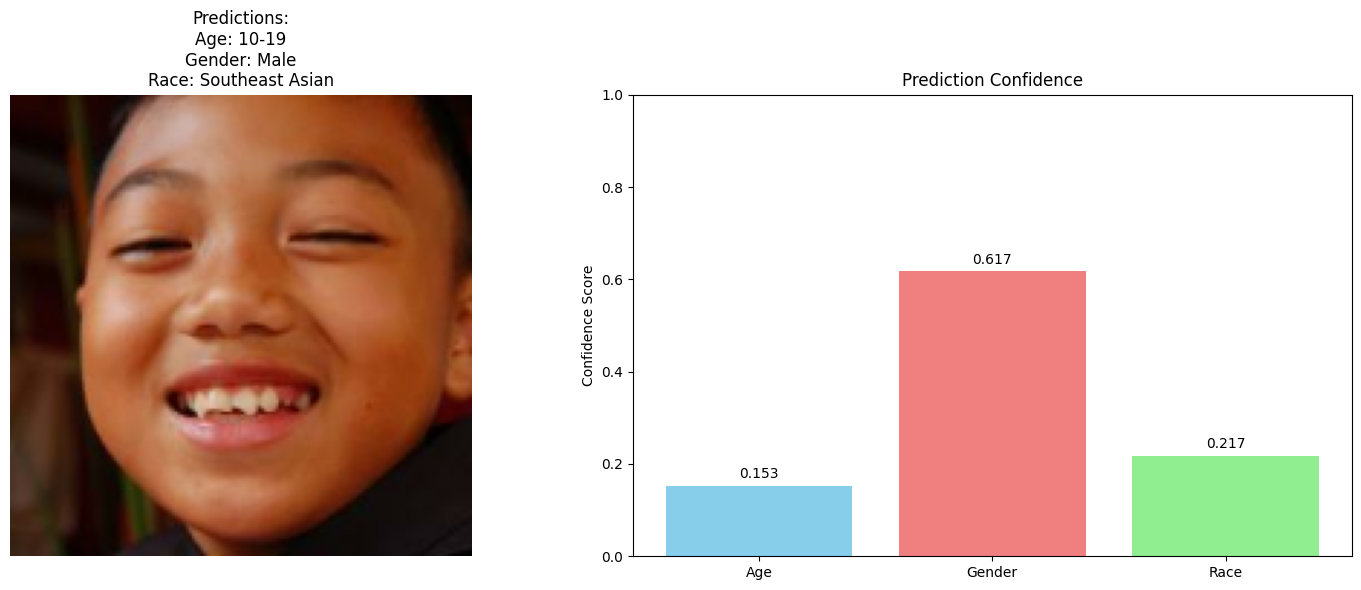


Detailed Predictions:
Age: 10-19 (confidence: 0.153)
Gender: Male (confidence: 0.617)
Race: Southeast Asian (confidence: 0.217)
{'age': {'predicted_class': np.int64(1), 'predicted_label': '10-19', 'confidence': np.float32(0.15332109), 'all_probabilities': array([0.09840804, 0.15332109, 0.1296037 , 0.1225383 , 0.1029772 ,
       0.09857874, 0.09821656, 0.09818196, 0.09817442], dtype=float32)}, 'gender': {'predicted_class': 1, 'predicted_label': 'Male', 'confidence': np.float32(0.61734116), 'probability': np.float32(0.61734116)}, 'race': {'predicted_class': np.int64(5), 'predicted_label': 'Southeast Asian', 'confidence': np.float32(0.21722735), 'all_probabilities': array([0.13380569, 0.16023289, 0.12256031, 0.12332454, 0.12123743,
       0.21722735, 0.12161171], dtype=float32)}}


In [31]:
predictions = predict_and_display(image_path)
print(predictions)

Explaining age prediction for C:/Users/DELL/Downloads/datasets/FairFace\val\10.jpg
Explainer ready for age task. Classes: ['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69', 'more than 70']

1. LIME Explanation:
------------------------------
Prediction: 10-19 (confidence: 0.153)
All class probabilities:
- 0-2: 0.098
- 10-19: 0.153
- 20-29: 0.130
- 3-9: 0.123
- 30-39: 0.103
- 40-49: 0.099
- 50-59: 0.098
- 60-69: 0.098
- more than 70: 0.098

Running LIME explanation with 500 samples...


100%|██████████| 500/500 [00:47<00:00, 10.51it/s]


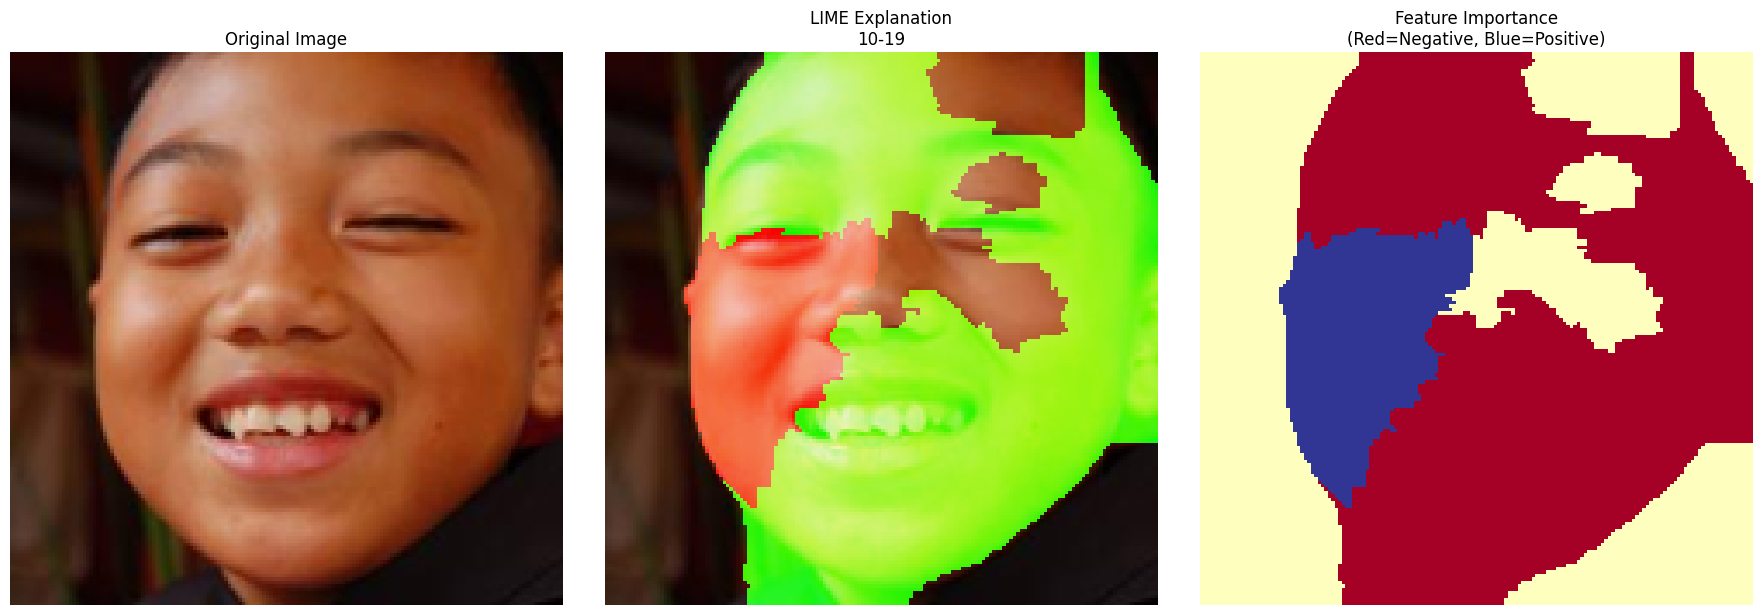


Top 8 superpixel contributions for '10-19' task:
1. Superpixel 14: 0.022 (positive)
2. Superpixel 3: 0.015 (positive)
3. Superpixel 7: 0.008 (positive)
4. Superpixel 16: 0.007 (positive)
5. Superpixel 10: -0.006 (negative)
6. Superpixel 17: 0.004 (positive)
7. Superpixel 15: -0.004 (negative)
8. Superpixel 11: -0.002 (negative)

2. GradCAM Explanation:
------------------------------
Using layer 'Block8_6_Conv2d_1x1' for GradCAM
GradCAM for: 10-19 (confidence: 0.153)
GradCAM explanation failed: gradient registry has no entry for: shap_BiasAdd

3. SHAP Explanation:
------------------------------
SHAP explainer initialized for age task
SHAP for: 10-19 (confidence: 0.153)
Computing SHAP values (max_evals=50)...
SHAP calculation failed: 'NoneType' object cannot be interpreted as an integer
{'lime': <lime.lime_image.ImageExplanation object at 0x00000268639043E0>, 'gradcam': None, 'shap': None}


In [38]:
explanations = explain_prediction_comprehensive(image_path, task='age')
print(explanations)